<a href="https://colab.research.google.com/github/Murilo1514/Diabets_prediction_pipeline/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Material base: https://www.kaggle.com/code/prashant111/svm-classifier-tutorial

a fazer: pca

In [ ]:
!pip install optuna
!pip install ucimlrepo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import optuna
from ucimlrepo import fetch_ucirepo
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import optuna
from plotly.io import show
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo
from functools import partial
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report



**CARREGANDO OS DADOS E SEPARANDO FEATURES E LABEL**

In [ ]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

X_dataset_sample = X
X_dataset_sample['y'] = y


X_dataset_sample = X_dataset_sample.sample(frac=0.005, random_state=42)

y_dataset_sample = X_dataset_sample['y']

X_dataset_sample.drop('y', axis = 1, inplace = True)

y_dataset_sample.value_counts()
# y_dataset_sample = y.sample(frac=0.005, random_state=42)


# metadata
#print(cdc_diabetes_health_indicators.metadata)

# variable information
#print(cdc_diabetes_health_indicators.variables)

<ipython-input-199-2ce18b883764>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count
y,
0,1091
1,177


**O sample é para diminuir o tempo de processamento, há 1268 linhas e 21 features**

In [ ]:
X_dataset_sample.shape

(1268, 21)

In [ ]:
X_dataset_sample.head()


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
219620,0,0,1,21,0,0,0,0,1,1,...,1,0,3,3,7,0,0,7,4,2
132821,1,1,1,28,0,0,0,1,1,1,...,1,0,3,0,0,0,0,13,6,6
151862,0,0,1,24,0,0,0,1,1,1,...,1,0,1,0,0,0,1,1,4,7
139717,0,0,1,27,1,0,0,1,0,1,...,1,0,2,3,0,0,1,2,4,7
239235,0,1,1,31,1,0,0,0,1,1,...,1,1,4,27,27,1,0,8,3,2


In [ ]:
X_colums = X_dataset_sample.columns
print(X_colums)

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


### **Descrição das features não binárias**

In [ ]:
description = X_dataset_sample[['BMI', 'MentHlth', 'GenHlth', 'PhysHlth', 'Age', 'Income']].describe().round(2)
print(description)

           BMI  MentHlth  GenHlth  PhysHlth      Age   Income
count  1268.00   1268.00  1268.00   1268.00  1268.00  1268.00
mean     28.47      2.99     2.49      4.10     7.94     6.10
std       6.66      7.19     1.05      8.63     3.04     2.07
min      16.00      0.00     1.00      0.00     1.00     1.00
25%      24.00      0.00     2.00      0.00     6.00     5.00
50%      27.00      0.00     2.00      0.00     8.00     7.00
75%      31.00      2.00     3.00      3.00    10.00     8.00
max      77.00     30.00     5.00     30.00    13.00     8.00


## **Análise de Outliers com gráfico boxplot**

In [ ]:
import matplotlib.pyplot as plt

# Lista das features desejadas
features = ['BMI', 'MentHlth', 'GenHlth', 'PhysHlth', 'Age', 'Income']

# Definindo o tamanho da figura ainda menor
plt.figure(figsize=(8, 6))  # Tamanho reduzido para gráficos menores

# Gerando boxplots para cada feature em uma grade 3x2 (3 colunas e 2 linhas)
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)  # Grade 2x3 (2 linhas, 3 colunas)
    fig = X_dataset_sample.boxplot(column=feature)  # Cria o boxplot para a feature
    fig.set_title(f'{feature}', fontsize=6)  # Título com fonte bem menor
    fig.set_ylabel(feature, fontsize=5)  # Rótulo do eixo Y com fonte ainda menor

# Ajustando o layout para que os gráficos não se sobreponham
plt.tight_layout()

# Exibindo os gráficos
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))  # Tamanho reduzido para gráficos menores

# Gerando histogramas para cada feature em uma grade 2x3 (2 linhas e 3 colunas)
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)  # Grade 2x3 (6 gráficos no total)
    fig = X_dataset_sample[feature].hist(bins=14)  # Criando o histograma para a feature
    plt.xlabel(feature, fontsize=8)  # Definindo o rótulo do eixo X com fonte menor
    plt.ylabel('Frequency', fontsize=8)  # Definindo o rótulo do eixo Y com fonte menor
    plt.title(f'Distribution of {feature}', fontsize=10)  # Título do gráfico com fonte menor

# Ajustando o layout para que os gráficos não se sobreponham
plt.tight_layout()

# Exibindo os gráficos
plt.show()


### **Split dos dados**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_sample, y_dataset_sample, test_size=0.2, random_state=51)

categorical_columns = ['GenHlth', 'Age', 'Education', 'Income']
numerical_columns = ['BMI', 'MentHlth', 'PhysHlth']

x_train_split, x_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=10, stratify=y_train)


In [ ]:
X_train.shape, X_test.shape


((1014, 21), (254, 21))

**## Padronização das features não Binárias!**

In [ ]:
numerical_features = ['BMI', 'MentHlth', 'GenHlth', 'PhysHlth', 'Age', 'Income']

scaler = StandardScaler()

# Aplicando o scaler apenas nas colunas numéricas
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Convertendo para DataFrame para manter as colunas e facilitar a visualização
X_train = pd.DataFrame(X_train, columns=X_dataset_sample.columns)
X_test = pd.DataFrame(X_test, columns=X_dataset_sample.columns)

# Visualizando estatísticas do X_train padronizado
print(X_train.describe())

            HighBP     HighChol    CholCheck           BMI       Smoker  \
count  1014.000000  1014.000000  1014.000000  1.014000e+03  1014.000000   
mean      0.428994     0.409270     0.967456  1.751831e-17     0.454635   
std       0.495177     0.491942     0.177528  1.000493e+00     0.498183   
min       0.000000     0.000000     0.000000 -1.845384e+00     0.000000   
25%       0.000000     0.000000     1.000000 -6.634058e-01     0.000000   
50%       0.000000     0.000000     1.000000 -2.201639e-01     0.000000   
75%       1.000000     1.000000     1.000000  3.708253e-01     1.000000   
max       1.000000     1.000000     1.000000  7.167201e+00     1.000000   

            Stroke  HeartDiseaseorAttack  PhysActivity       Fruits  \
count  1014.000000           1014.000000   1014.000000  1014.000000   
mean      0.034517              0.089744      0.755424     0.613412   
std       0.182642              0.285955      0.430048     0.487208   
min       0.000000              0.000000

### **TESTE-- PADRONIZAÇÃO DE TODAS AS FEATURES**

In [ ]:

# Inicializando o scaler
scaler = StandardScaler()

# Aplicando o scaler em todas as colunas
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertendo de volta para DataFrame para manter as colunas e facilitar a visualização
X_train = pd.DataFrame(X_train, columns=X_dataset_sample.columns)
X_test = pd.DataFrame(X_test, columns=X_dataset_sample.columns)

# Visualizando estatísticas do X_train padronizado
print(X_train.describe())


             HighBP      HighChol     CholCheck           BMI        Smoker  \
count  1.014000e+03  1.014000e+03  1.014000e+03  1.014000e+03  1.014000e+03   
mean  -5.255494e-17 -1.751831e-18  2.934317e-16  2.347454e-16  6.656959e-17   
std    1.000493e+00  1.000493e+00  1.000493e+00  1.000493e+00  1.000493e+00   
min   -8.667729e-01 -8.323589e-01 -5.452272e+00 -1.845384e+00 -9.130360e-01   
25%   -8.667729e-01 -8.323589e-01  1.834098e-01 -6.634058e-01 -9.130360e-01   
50%   -8.667729e-01 -8.323589e-01  1.834098e-01 -2.201639e-01 -9.130360e-01   
75%    1.153705e+00  1.201405e+00  1.834098e-01  3.708253e-01  1.095247e+00   
max    1.153705e+00  1.201405e+00  1.834098e-01  7.167201e+00  1.095247e+00   

             Stroke  HeartDiseaseorAttack  PhysActivity        Fruits  \
count  1.014000e+03          1.014000e+03  1.014000e+03  1.014000e+03   
mean  -3.503662e-17          5.167902e-17  6.481775e-17 -1.270078e-16   
std    1.000493e+00          1.000493e+00  1.000493e+00  1.000493e+00

### **Run SVM with default hyperparameters**

In [ ]:
# instantiate classifier with default hyperparameters
#svc=SVC(class_weight='balanced')

svc=SVC()

# fit classifier to training set
svc.fit(X_train,y_train.values.ravel())


# make predictions on test set
y_pred_test=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with default hyperparameters: 0.8622


In [ ]:
print(y_pred_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
svc=SVC(C=100.0)


# fit classifier to training set
svc.fit(X_train,y_train.values.ravel())


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.8346


### **Run SVM with linear kernel**

In [ ]:
linear_svc=SVC(kernel='linear', C=1.0, class_weight='balanced')

# fit classifier to training set
linear_svc.fit(X_train,y_train.values.ravel())


# make predictions on test set
y_pred_test=linear_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))



Model accuracy score with linear kernel and C=1.0 : 0.7087


In [ ]:
y_pred_test

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0)


# fit classifier to training set
linear_svc100.fit(X_train, y_train.values.ravel())


# make predictions on test set
y_pred=linear_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=100.0 : 0.8661


Compare the train-set and test-set accuracy

In [ ]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


Training-set accuracy score: 0.7081


### **Check for overfitting and underfitting**

In [ ]:
print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

Training set score: 0.7081
Test set score: 0.7244


In [ ]:
y_test.value_counts()


,count
y,
0,220
1,34


In [ ]:
y_train.value_counts()

,count
y,
0,871
1,143


## **VOU USAR KERNEL: POLY  -->  C=1.4 : 0.7165  <-- PQ OS OUTROS ESTÃO CHUTANDO TUDO 0 E TA COM SCORE ALTO DEVIDO A MAIORIA SER 0 MESMO.**

In [ ]:
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0)


# fit classifier to training set
poly_svc.fit(X_train,y_train.values.ravel())


# make predictions on test set
y_pred=poly_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with polynomial kernel and C=1.0 : 0.8661


In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=1.40,class_weight='balanced')


# fit classifier to training set
poly_svc100.fit(X_train, y_train.values.ravel())


# make predictions on test set
y_pred_test=poly_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.4 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with polynomial kernel and C=1.4 : 0.8189


In [ ]:
y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0)


# fit classifier to training set
sigmoid_svc.fit(X_train,y_train.values.ravel())


# make predictions on test set
y_pred_test=sigmoid_svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with sigmoid kernel and C=1.0 : 0.8661


In [ ]:
# instantiate classifier with sigmoid kernel and C=100.0
sigmoid_svc100=SVC(kernel='sigmoid', C=100.0)


# fit classifier to training set
sigmoid_svc100.fit(X_train,y_train.values.ravel())


# make predictions on test set
y_pred=sigmoid_svc100.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=100.0 : 0.7913


### **METRICS DO MODELO SVC PADRÃO**

In [ ]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives (TP) = ', cm[1, 1])
print('True Negatives (TN) = ', cm[0, 0])
print('False Positives (FP) = ', cm[0, 1])
print('False Negatives (FN) = ', cm[1, 0])


Confusion matrix

 [[194  26]
 [ 20  14]]

True Positives (TP) =  14
True Negatives (TN) =  194
False Positives (FP) =  26
False Negatives (FN) =  20


In [ ]:
x = (194+14)/(194+14+26+20)
print(x)

0.8188976377952756


<Axes: >

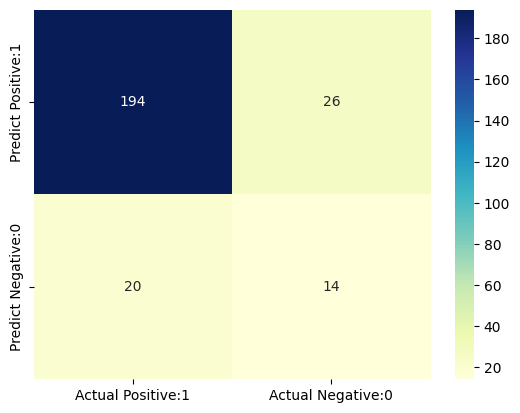

In [ ]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       444
           1       0.56      0.08      0.14        64

    accuracy                           0.88       508
   macro avg       0.72      0.53      0.54       508
weighted avg       0.84      0.88      0.83       508



In [ ]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [ ]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.8760


In [ ]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.1240


In [ ]:
precision = TP / float(TP + FP)

print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9910


In [ ]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.8818


In [ ]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.8818


In [ ]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.4444


In [ ]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.5556


### ROC - AUC

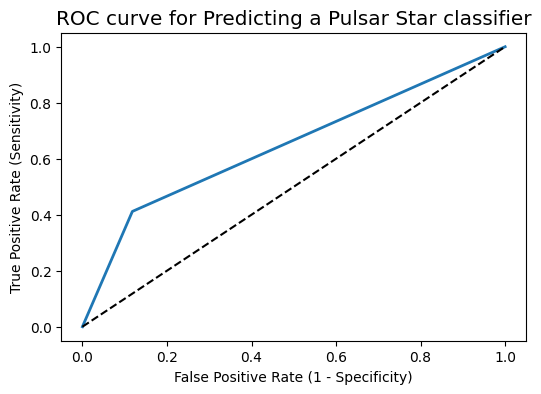

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting a Pulsar Star classifier')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [ ]:
X_train.sample()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
111,-0.866773,1.201405,0.18341,-0.663406,-0.913036,-0.189079,-0.313993,-1.757473,0.793867,0.491046,...,0.210438,-0.284646,0.476283,-0.409238,-0.472631,-0.418295,-0.900397,0.995137,0.97786,0.437863
